In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# simulation parameters
dt, x0, a = 0.1, 0, 10
J, N, M = 100, 10**5, 200
b_weak, b_strong = 1, 10

#### Maximum Likelihood and Bayesian Inference

In [3]:
np.random.seed(1047)

def V(x, a):
    return a*x

def mle_map_trajectory(J, N, M, a, b, mle):
    
    # simulate trajectories
    
    # Brownian increments
    dw = np.sqrt(dt) * np.random.randn(N+1, J)
    
    # discretized path of X(t)
    x = np.zeros((N + 1, J))
    x[0] = x0
    
    for i in range(N):
        x[i+1] = x[i] - V(x[i], a) * dt - b * (x[i] - np.mean(x[i])) * dt + dw[i]
        
    # num and denom of estimators
    dx = np.diff(x, axis = 0)
    num = np.cumsum((dx[1:] + V(x[1:-1], a) * dt) * (x[1:-1] - np.mean(x[1:-1])), axis = 0)
    denom = np.cumsum((x[1:-1] - np.mean(x[1:-1]))**2, axis = 0)
    
    if mle:
        
        # max likelihood estimate
        estimator = -(1/dt) * (num[M:]/denom[M:])
    else:
        
        # map estimator
        estimator = (2 - num[M:])/(1 + denom[M:] * dt)
    
    # statistics
    mse = np.mean((estimator - b)**2, axis = 1)
    variance = np.var(estimator, axis = 1)
    
    return estimator, mse, variance


#### Stochastic Gradient Descent

In [4]:
np.random.seed(1047)

t = np.linspace(0, N*dt, N+1)

# learning rate
lr = 0.8
alpha = lambda t: min(lr, lr/t) if t>0 else lr

# drift function
def f(x, a, b):
    return -a*x - b*(x - np.mean(x))

# Euler Maruyama scheme
def sgd_trajectory(J, N, a, b):
    
    # Brownian increments
    dw = np.sqrt(dt) * np.random.randn(N+1, J)
    
    # initial values for the estimate b of b*
    est = np.zeros((N+1, J))
    est[0,:] = np.random.uniform(low = 0, high = 1, size = (1, J))
    
    # path of X(t)
    x = np.zeros((N+1, J))
    x[0,:] = x0
    
    for i in range(N):
        
        # simulate a single path in each case J given θ*
        x[i+1] = x[i] + f(x[i], a, b) * dt + dw[i]
        
        # simultaneously solve for path b(t)
        est[i+1] = est[i] - alpha(t[i]) * (x[i] - np.mean(x[i])) * (x[i+1] - x[i] - f(x[i], a, est[i]) * dt)
        
    # statistics
    mse = np.mean((est - b)**2, axis = 1)
    var = np.var(est, axis = 1)
    
    return est, mse, var

#### Compare time evolution and MSE

In [32]:
def performance_plots(b, b_mle, b_map, b_sgd, mse_mle, mse_map, mse_sgd, weak):

    fig, axs = plt.subplots(3, 2, figsize = (11, 7.1))
    
    if weak:
        fig.suptitle(r'Weak interaction $(\beta = {})$'.format(b), fontsize = 13.5)
    else:
        fig.suptitle(r'Strong interaction $(\beta = {})$'.format(b), fontsize = 13.5)

    t_off = np.linspace(0, N*dt, N-1)[M:]
    t_on = np.linspace(0, N*dt, N+1)[M:]

    # maximum likelihood

    axs[0,0].plot(t_off, b_mle)
    axs[0,0].plot(t_off, 0*t_off + b, ls = '--', color = 'b', linewidth = 1.6, label = r"True $\beta$")
    axs[0,0].set_xscale('log', basex = 2)
    axs[0,0].set_xlabel('Time')
    axs[0,0].set_ylabel(r'$\hat \beta_{MLE}$', labelpad = 1, fontsize = 13.4)
    axs[0,0].legend(loc = 'upper right', bbox_to_anchor = (0.97, 0.97), prop = {'size': 12.5}, 
                    handlelength = 2.2, frameon = False)

    axs[0,1].plot(t_off, mse_mle, linewidth = 1.8, label = r"$MSE[\hat \beta_{MLE}]$")
    axs[0,1].set_xscale('log', basex = 2)
    axs[0,1].set_xlabel('Time')
    axs[0,1].set_ylabel('Value', fontsize = 13.5)
    axs[0,1].legend(loc = 'upper right', bbox_to_anchor = (0.97, 0.97), prop = {'size': 12.5}, frameon = False)

    # bayesian inference

    axs[1,0].plot(t_off, b_map)
    axs[1,0].plot(t_off, 0*t_off + b, ls = '--', color = 'b', linewidth = 1.6, label = r"True $\beta$")
    axs[1,0].set_xscale('log', basex = 2)
    axs[1,0].set_xlabel('Time')
    axs[1,0].set_ylabel(r'$\hat \beta_{MAP}$', labelpad = 1, fontsize = 13.4)
    axs[1,0].legend(loc = 'upper right', bbox_to_anchor = (0.97, 0.9), prop = {'size': 12.5}, 
                    handlelength = 2.2, frameon = False)

    axs[1,1].plot(t_off, mse_map, linewidth = 1.8, label = r"$MSE[\hat \beta_{MAP}]$")
    axs[1,1].set_xscale('log', basex = 2)
    axs[1,1].set_xlabel('Time')
    axs[1,1].set_ylabel('Value', fontsize = 13.5)
    axs[1,1].legend(loc = 'upper right', bbox_to_anchor = (0.97, 0.97), prop = {'size': 12.5}, frameon = False)

    # stochastic gradient descent

    axs[2,0].plot(t_on, b_sgd[M:])
    axs[2,0].plot(t_on, 0*t_on + b, ls = '--', color = 'b', linewidth = 1.6, label = r"True $\beta$")
    axs[2,0].set_xlabel('Time')
    axs[2,0].set_xscale('log', basex = 2)
    axs[2,0].set_ylabel(r'$\hat \beta_{SGD}$', labelpad = -0.2, fontsize = 13.4)
    axs[2,0].legend(loc = 'lower right', bbox_to_anchor = (0.97, 0.02), prop = {'size': 12.5}, 
                    handlelength = 2.2, frameon = False)

    axs[2,1].plot(t_on, mse_sgd[M:], linewidth = 1.8, label = r"$MSE[\hat \beta_{SGD}]$")
    axs[2,1].set_xlabel('Time')
    axs[2,1].set_xscale('log', basex = 2)
    axs[2,1].set_ylabel('Value', fontsize = 13.5)
    axs[2,1].legend(loc = 'upper right', bbox_to_anchor = (0.97, 0.97), prop = {'size': 12.5}, frameon = False)

    plt.subplots_adjust(top = 0.94, wspace = 0.23, hspace = 0.3)
    plt.show()

#### Compare variance

In [26]:
# compare variance of MLE, MAP, SGD
def variance_plots(b, M, var_mle, var_map, var_sgd, weak):

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 5.8))
    
    if weak:
        fig.suptitle(r'Weak interaction $(\beta = {})$'.format(b), fontsize = 13.5)
    else:
        fig.suptitle(r'Strong interaction $(\beta = {})$'.format(b), fontsize = 13.5)

    t_off = np.linspace(0, N*dt, N-1)[M:]
    t_on = np.linspace(0, N*dt, N+1)[M:]

    ax1.set_xlabel('Time')
    ax1.set_xscale('log', basex = 2)
    ax1.set_ylabel('Value', fontsize = 13.5)
    ax1.plot(t_off, var_mle, linewidth = 1.8, label = r"$Var[\hat \beta_{MLE}]$")
    ax1.legend(loc = 'upper right', bbox_to_anchor = (0.97, 0.97), prop = {'size': 12.5}, frameon = False)

    ax2.set_xlabel('Time')
    ax2.set_xscale('log', basex = 2)
    ax2.set_ylabel('Value', fontsize = 13.5)
    ax2.plot(t_off, var_map, linewidth = 1.8, label = r"$Var[\hat \beta_{MAP}]$")
    ax2.legend(loc = 'upper right', bbox_to_anchor = (0.97, 0.97), prop = {'size': 12.5}, frameon = False)

    ax3.set_xlabel('Time')
    ax3.set_xscale('log', basex = 2)
    ax3.set_ylabel('Value', fontsize = 13.5)
    ax3.plot(t_on, var_sgd[M:], linewidth = 1.8, label = r"$Var[\hat \beta_{SGD}]$")
    ax3.legend(loc = 'upper right', bbox_to_anchor = (0.97, 0.97), prop = {'size': 12.5}, frameon = False)

    plt.subplots_adjust(top = 0.94, hspace = 0.4)
    plt.show()

#### Weak interaction (b = 1)

In [9]:
# simulation
b_mle_weak, mse_mle_weak, var_mle_weak = mle_map_trajectory(J, N, M, a, b = b_weak, mle = True)
b_map_weak, mse_map_weak, var_map_weak = mle_map_trajectory(J, N, M, a, b = b_weak, mle = False)
b_sgd_weak, mse_sgd_weak, var_sgd_weak = sgd_trajectory(J, N, a, b = b_weak)

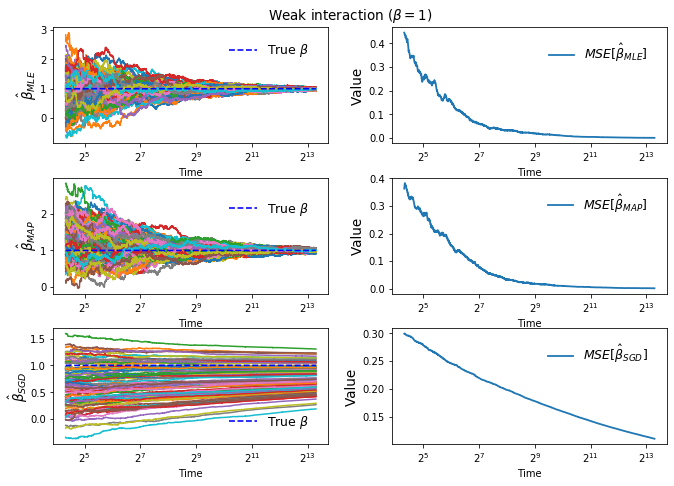

In [33]:
performance_plots(b_weak, b_mle_weak, b_map_weak, b_sgd_weak, mse_mle_weak, mse_map_weak, mse_sgd_weak, weak = True)

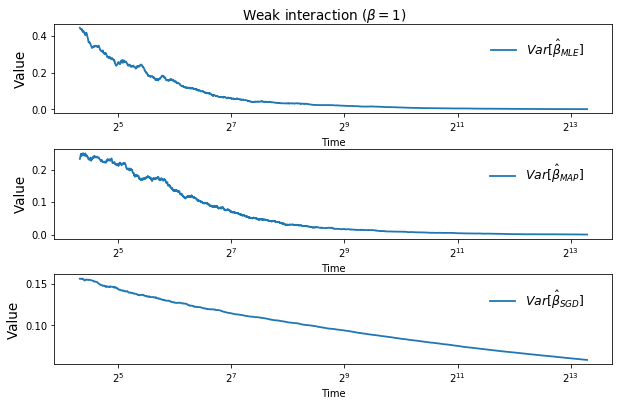

In [27]:
variance_plots(b_weak, M, var_mle_weak, var_map_weak, var_sgd_weak, weak = True)

#### Strong interaction (b = 10)

In [14]:
b_mle_strong, mse_mle_strong, var_mle_strong = mle_map_trajectory(J, N, M, a, b = b_strong, mle = True)
b_map_strong, mse_map_strong, var_map_strong = mle_map_trajectory(J, N, M, a, b = b_strong, mle = False)
b_sgd_strong, mse_sgd_strong, var_sgd_strong = sgd_trajectory(J, N, a, b = b_strong)

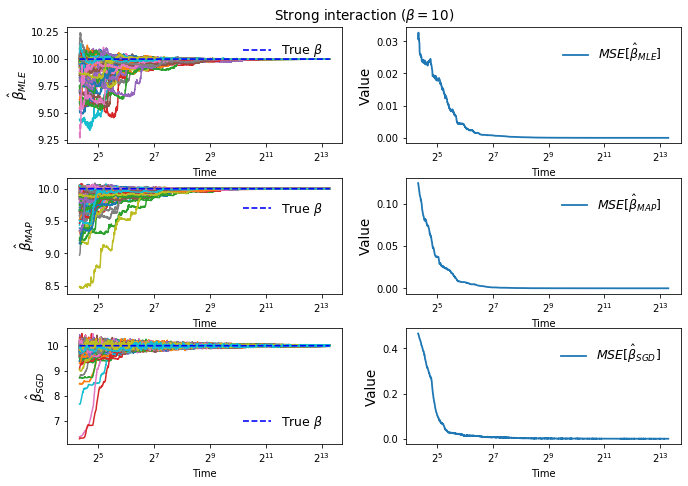

In [34]:
performance_plots(b_strong, b_mle_strong, b_map_strong, b_sgd_strong, mse_mle_strong, mse_map_strong, mse_sgd_strong, weak = False)

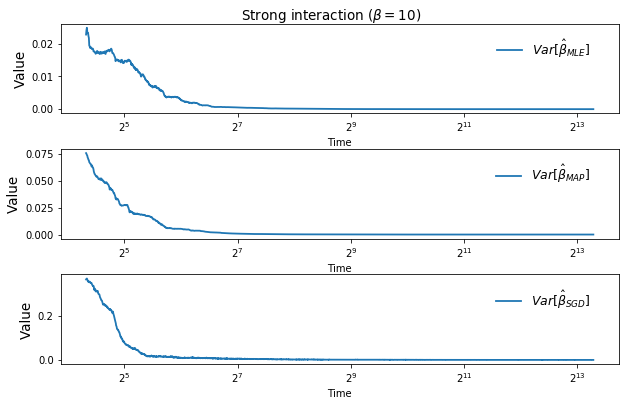

In [28]:
variance_plots(b_strong, M, var_mle_strong, var_map_strong, var_sgd_strong, weak = False)